In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
jax.config.update("jax_enable_x64", True)  # Use double precision
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")

import numpy as np

from hemcee.kernels.hmc import hmc
from hemcee.kernels.hmc_walk import hamiltonian_walk_move
from hemcee.kernels.hmc_side import hamiltonian_side_move

import corner

JAX version: 0.4.30
Available devices: [CpuDevice(id=0)]


# Target Distribution

In [3]:
# Parameters
dim = 3  # Dimension of the problem
cond_number = 1.0

# Generate random key for JAX
key = random.PRNGKey(42)

# Create precision matrix using JAX
eigenvals = 0.1 * jnp.linspace(1, cond_number, dim)
H = random.normal(key, (dim, dim))
Q, _ = jnp.linalg.qr(H)
precision = Q @ jnp.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)  # Ensure symmetry

precision = jnp.eye(dim)
def log_prob(x):
    return 0.5 * jnp.einsum('i,ij,j->', x, precision, x)

print(f"Precision matrix shape: {precision.shape}")
print(f"Condition number: {jnp.linalg.cond(precision):.2f}")
print(f"Is symmetric: {jnp.allclose(precision, precision.T)}")
print(f"Is positive definite: {jnp.all(jnp.linalg.eigvals(precision) > 0)}")


Precision matrix shape: (3, 3)
Condition number: 1.00
Is symmetric: True
Is positive definite: True


# Sampler

In [4]:
burn_in = 1e4
n_samples = int(1e5)
n_chains = 10
step_size = 0.001

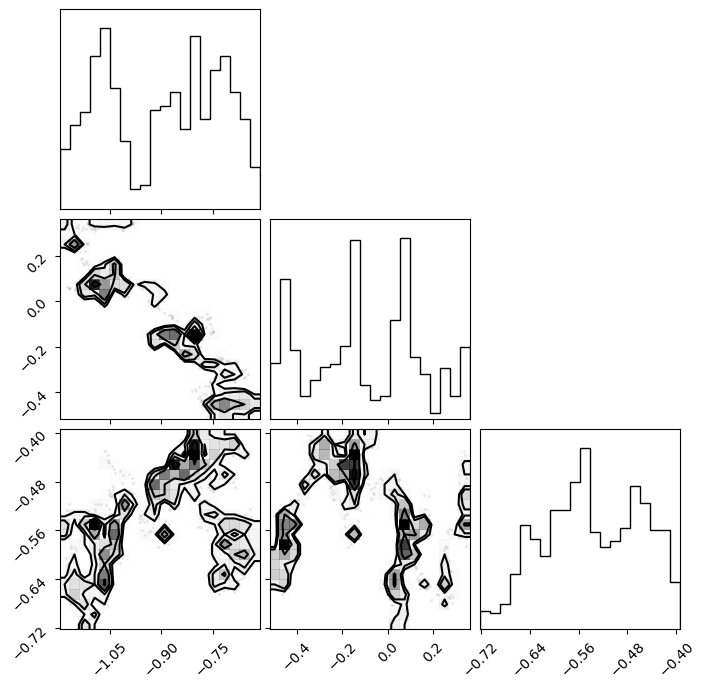

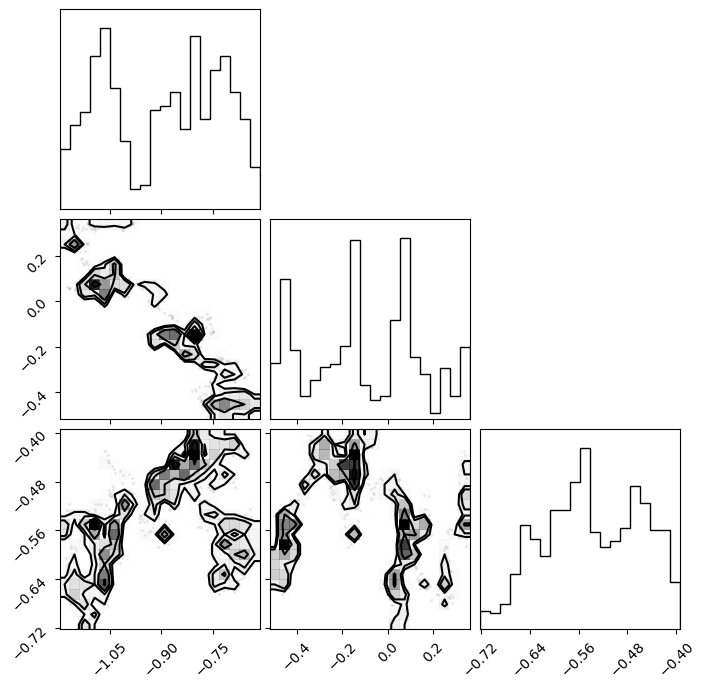

In [5]:
samples, acceptance_rates = hmc(
    log_prob, 
    jnp.zeros(dim), 
    n_samples, 
    step_size=step_size,
    n_chains=n_chains
)
samples = samples.reshape(-1, dim)
corner.corner(np.array(samples)[-1000:, :])

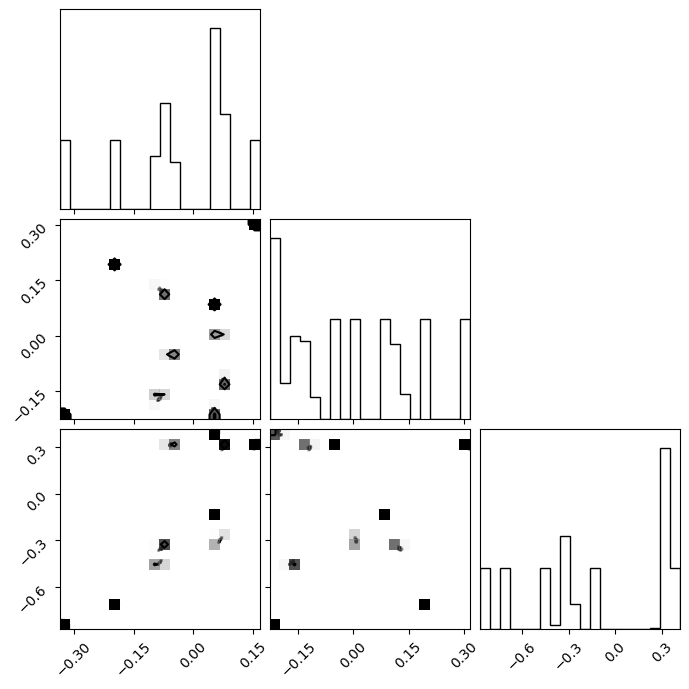

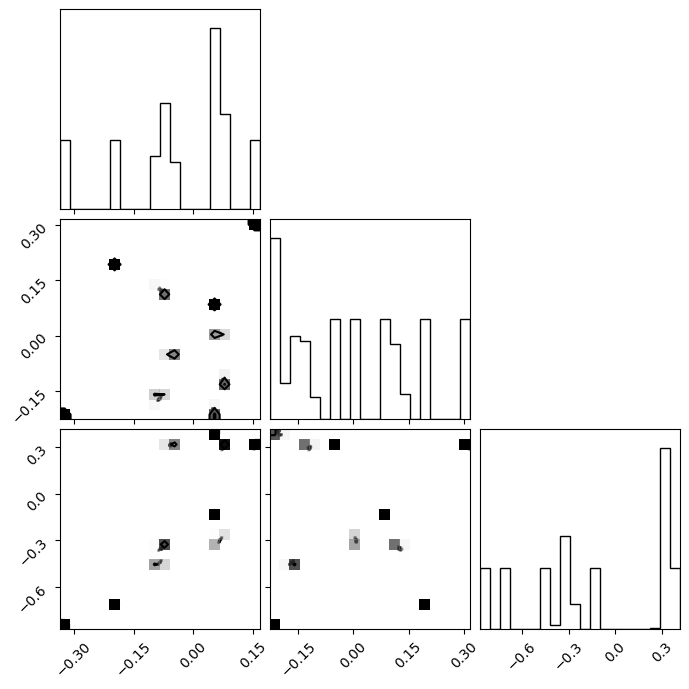

In [8]:
samples, acceptance_rates = hamiltonian_side_move(
    log_prob, 
    jnp.zeros(dim), 
    n_samples,
    step_size=step_size,
)
samples = samples.reshape(-1, dim)
corner.corner(np.array(samples)[-1000:, :])

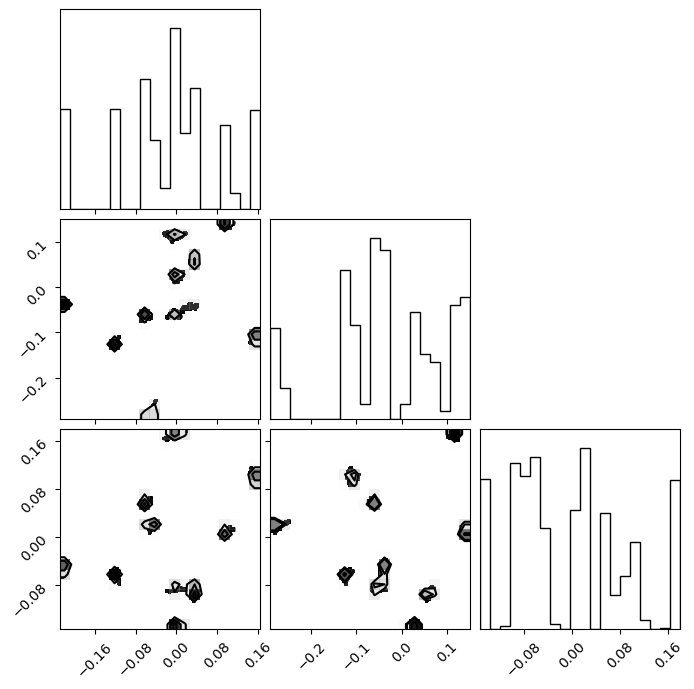

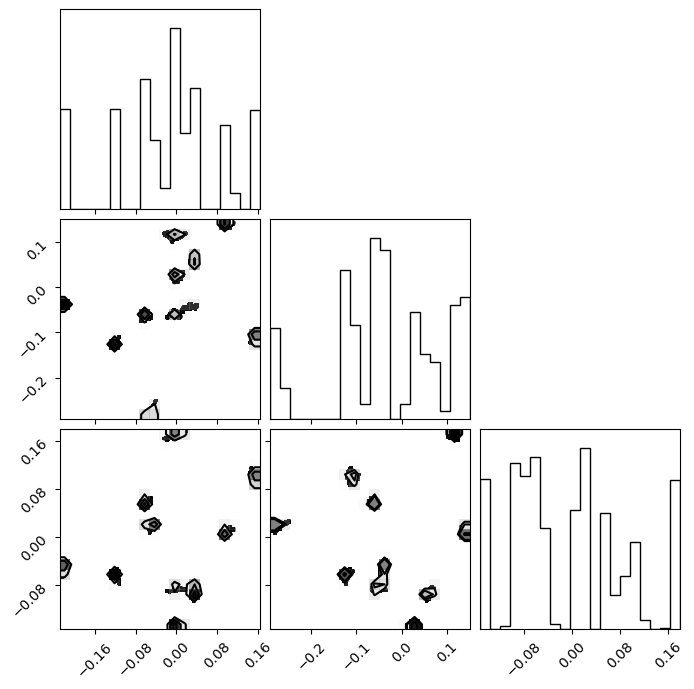

In [7]:
samples, acceptance_rates = hamiltonian_walk_move(
    log_prob, 
    jnp.zeros(dim), 
    n_samples,
    step_size=step_size,
)
samples = samples.reshape(-1, dim)
corner.corner(np.array(samples))